In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from utils.aoj import AspenOpenJets 
from utils.datasets import jet_set_to_seq

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch1.h5"
)

num_jets = 50_000
max_num_particles = 150

data, metadata = aoj(num_jets=num_jets,
                      download=False,      
                      max_num_particles=max_num_particles,           
                      features={"continuous": ['pt', 'eta_rel', 'phi_rel'], "discrete": "tokens"},
                      pt_order=True,
                      padding='zeros',
                      )


/home/df630/Multimodal-flows/multimodal_flows/utils/aoj.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_discrete_feats.append(torch.tensor(feats[features["discrete"]]))


In [ ]:
import numpy as np
import torch
from argparse import ArgumentParser
from pytorch_lightning.loggers import CometLogger
import pytorch_lightning as L
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from transformers import GPT2Config

from utils.tensorclass import TensorMultiModal
from utils.aoj import AspenOpenJets 
from utils.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn
from utils.callbacks import GPTGeneratorCallback
from model.MMF import MultiModalFlowBridge


experiment_id = "efb5ee16ee754d639dfd041b33e8883c"
num_jets = 100

mmf = MultiModalFlowBridge.load_from_checkpoint(f"/home/df630/Multimodal-flows/jet_sequences/{experiment_id}/checkpoints/best.ckpt")
mmf.num_timesteps = 100
#...dataset & dataloaders:


aoj = AspenOpenJets(data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch1.h5")
test, _ = aoj(num_jets=num_jets,
                download=False,
                features={"continuous": ['pt', 'eta_rel', 'phi_rel'], "discrete": "tokens"},
                pt_order=True,
                padding='zeros')


gauss_noise = torch.randn_like(test.continuous) * test.mask
cat_noise = torch.randint_like(test.discrete, 1, mmf.vocab_size) * test.mask
t0 = torch.full((len(cat_noise),), mmf.time_eps)  # (B) t_0=eps

source = TensorMultiModal(continuous=gauss_noise, discrete=cat_noise, mask=test.mask.clone(), time=t0)
source = source.to(mmf.device)


data = DataCoupling(source=source, target=TensorMultiModal())

sample = mmf.simulate_dynamics(data)
sample.target.apply_mask()
sample = sample.target.detach().cpu() 


In [34]:
sample.continuous =  sample.continuous * mmf.std + mmf.mean


AttributeError: 'MultiModalFlowBridge' object has no attribute 'std'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.histplot(test.continuous[...,0], discrete=True, stat="density", element="step", fill=True, lw=0.0)
sns.histplot(sample.continuous[...,0], discrete=True, stat="density",element="step", fill=False, lw=0.75)

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_flavor_feats(sample, particle_set, path_dir=None):

    #...Low-level feats

    fig, ax = plt.subplots(2, 4, figsize=(10,3.5))

    sns.histplot((particle_set.discrete == 1).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
    sns.histplot((sample == 1).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
    ax[0, 0].set_xlabel(r"$N_{\gamma}$")

    sns.histplot((particle_set.discrete == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
    sns.histplot((sample == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
    ax[0, 1].set_xlabel(r"$N_{h^0}$")

    sns.histplot((particle_set.discrete == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
    sns.histplot((sample == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
    ax[0, 2].set_xlabel(r"$N_{h^{-}}$")

    sns.histplot((particle_set.discrete == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 3],lw=0.0)
    sns.histplot((sample == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 3],lw=0.75)
    ax[0, 3].set_xlabel(r"$N_{h^{+}}$")

    sns.histplot((particle_set.discrete == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
    sns.histplot((sample == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
    ax[1, 0].set_xlabel(r"$N_{e^{-}}$")

    sns.histplot((particle_set.discrete == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
    sns.histplot((sample == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
    ax[1, 1].set_xlabel(r"$N_{e^{+}}$")

    sns.histplot((particle_set.discrete == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
    sns.histplot((sample == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
    ax[1, 2].set_xlabel(r"$N_{\mu^{-}}$")

    sns.histplot((particle_set.discrete == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 3],lw=0.0)
    sns.histplot((sample == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 3],lw=0.75)
    ax[1, 3].set_xlabel(r"$N_{\mu^{+}}$")

    plt.tight_layout()
    for a in ax.flatten():
        a.legend([], [], frameon=False)


    #...High-level feats

    fig, ax = plt.subplots(2, 3, figsize=(8,3.5))

    sns.histplot((particle_set.discrete > 0).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
    sns.histplot((sample > 0).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
    ax[0, 0].set_xlabel(r"$N$")

    sns.histplot(((particle_set.discrete > 1) & (particle_set.discrete < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
    sns.histplot(((sample > 1) & (sample < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
    ax[0, 1].set_xlabel(r"$N_{\rm had}$")

    sns.histplot((particle_set.discrete > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
    sns.histplot((sample > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
    ax[0, 2].set_xlabel(r"$N_{\rm lep}$")

    sns.histplot(((particle_set.discrete == 1) | (particle_set.discrete == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
    sns.histplot(((sample == 1) | (sample == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
    ax[1, 0].set_xlabel(r"$N_{0}$")

    sns.histplot(((particle_set.discrete == 3) | (particle_set.discrete == 5) | (particle_set.discrete == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
    sns.histplot(((sample == 3) | (sample == 5) | (sample == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
    ax[1, 1].set_xlabel(r"$N_{-}$")

    sns.histplot(((particle_set.discrete == 4) | (particle_set.discrete == 6) | (particle_set.discrete == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
    sns.histplot(((sample == 4) | (sample == 6) | (sample == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
    ax[1, 2].set_xlabel(r"$N_{+}$")


    plt.tight_layout()
    for a in ax.flatten():
        a.legend([], [], frameon=False)



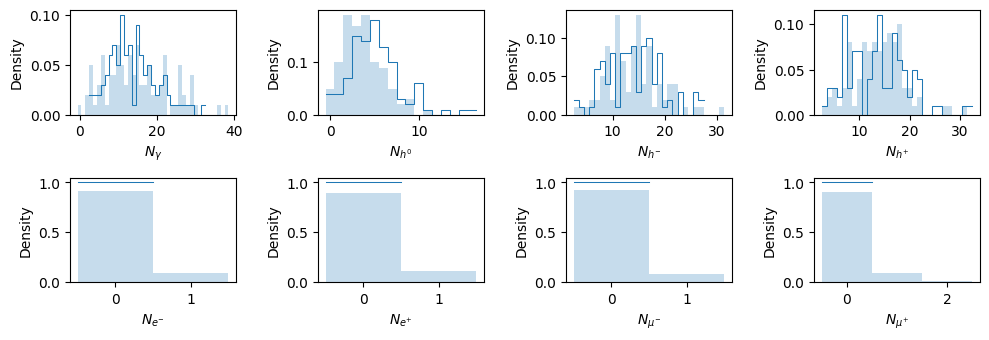

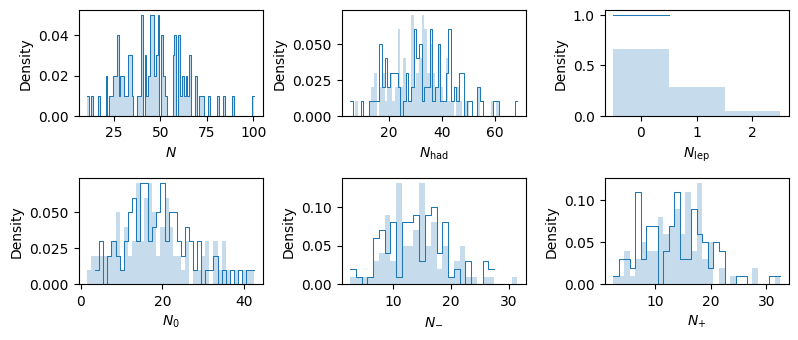

In [15]:

plot_flavor_feats(sample.discrete, 
                  test)

<Axes: ylabel='Density'>

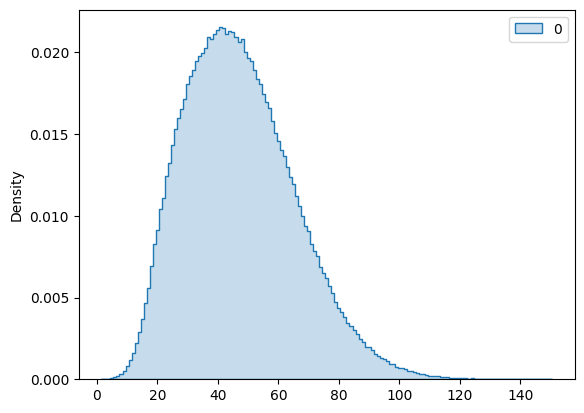

In [2]:
import seaborn as sns

sns.histplot((particle_set.discrete > 0).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             )

In [47]:
import torch
from pytorch_lightning.loggers import CometLogger
import pytorch_lightning as L
from torch.utils.data import DataLoader, random_split
from tensorclass import TensorMultiModal
from datamodules.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn
from model.GPT import JetFlavorSeqGPT


experiment_id = 'efb5ee16ee754d639dfd041b33e8883c'
gpt = JetFlavorSeqGPT.load_from_checkpoint(f"/home/df630/Multimodal-flows/jet_sequences/{experiment_id}/checkpoints/best.ckpt", map_location="cpu",)


ModuleNotFoundError: No module named 'tensorclass'

In [53]:
import torch.nn.functional as F

prompts = torch.full((1000, 1), gpt.start_token, dtype=torch.long)
attention_mask = torch.ones_like(prompts)

samples = gpt.model.generate(
                            input_ids=prompts,
                            attention_mask=attention_mask,
                            max_new_tokens=gpt.max_seq_length + 2, 
                            do_sample=True,
                            temperature=gpt.temperature,
                            top_k=gpt.top_k,
                            eos_token_id=gpt.end_token,
                            pad_token_id=gpt.pad_token,
                            )

preds = F.pad(samples, (0, gpt.max_seq_length + 2 - samples.shape[1]), value=gpt.pad_token)
preds = torch.where(preds >= gpt.start_token, 0, preds)[:, 1:-1]  # remove start token

In [54]:
preds

tensor([[3, 3, 4,  ..., 0, 0, 0],
        [3, 2, 1,  ..., 0, 0, 0],
        [3, 1, 4,  ..., 0, 0, 0],
        ...,
        [3, 2, 1,  ..., 0, 0, 0],
        [1, 3, 3,  ..., 0, 0, 0],
        [4, 1, 3,  ..., 0, 0, 0]])

In [3]:
sample = np.load('/home/df630/Multimodal-flows/jet_sequences/sample.npy')
sample = torch.from_numpy(sample).long()
sample.shape

torch.Size([500000, 150])

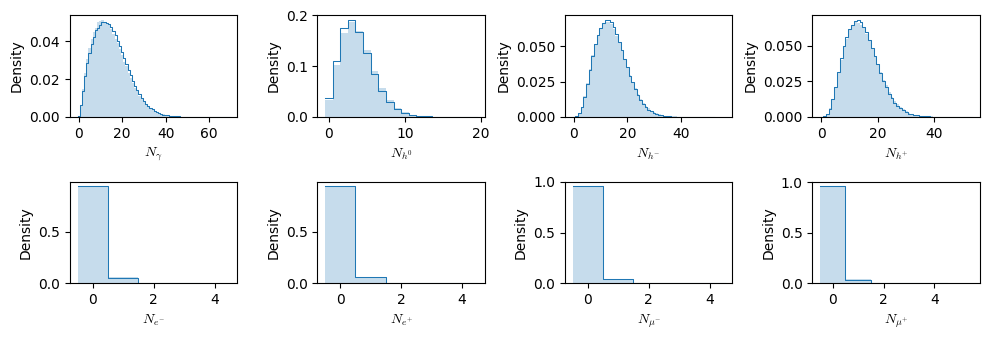

In [34]:
import seaborn as sns

fig, ax = plt.subplots(2, 4, figsize=(10,3.5))

sns.histplot((particle_set.discrete == 1).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
sns.histplot((sample == 1).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
ax[0, 0].set_xlabel(r"$N_{\gamma}$")

sns.histplot((particle_set.discrete == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
sns.histplot((sample == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
ax[0, 1].set_xlabel(r"$N_{h^0}$")

sns.histplot((particle_set.discrete == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
sns.histplot((sample == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
ax[0, 2].set_xlabel(r"$N_{h^{-}}$")

sns.histplot((particle_set.discrete == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 3],lw=0.0)
sns.histplot((sample == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 3],lw=0.75)
ax[0, 3].set_xlabel(r"$N_{h^{+}}$")

sns.histplot((particle_set.discrete == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
sns.histplot((sample == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
ax[1, 0].set_xlabel(r"$N_{e^{-}}$")

sns.histplot((particle_set.discrete == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
sns.histplot((sample == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
ax[1, 1].set_xlabel(r"$N_{e^{+}}$")

sns.histplot((particle_set.discrete == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
sns.histplot((sample == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
ax[1, 2].set_xlabel(r"$N_{\mu^{-}}$")

sns.histplot((particle_set.discrete == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 3],lw=0.0)
sns.histplot((sample == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 3],lw=0.75)
ax[1, 3].set_xlabel(r"$N_{\mu^{+}}$")

plt.tight_layout()
for a in ax.flatten():
    a.legend([], [], frameon=False)
plt.show()


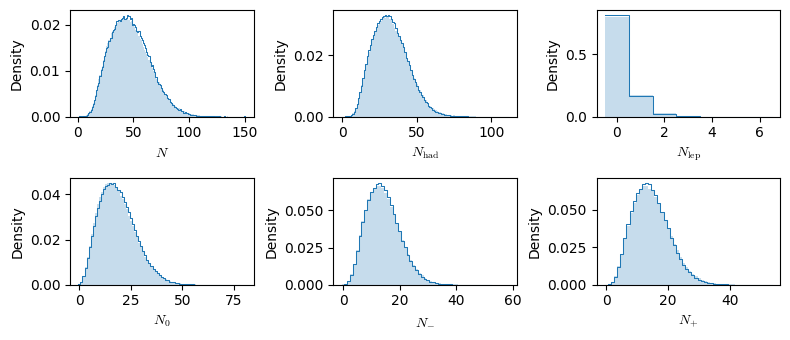

In [49]:
import seaborn as sns

fig, ax = plt.subplots(2, 3, figsize=(8,3.5))

sns.histplot((particle_set.discrete > 0).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
sns.histplot((sample > 0).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
ax[0, 0].set_xlabel(r"$N$")

sns.histplot(((particle_set.discrete > 1) & (particle_set.discrete < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
sns.histplot(((sample > 1) & (sample < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
ax[0, 1].set_xlabel(r"$N_{\rm had}$")

sns.histplot((particle_set.discrete > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
sns.histplot((sample > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
ax[0, 2].set_xlabel(r"$N_{\rm lep}$")

sns.histplot(((particle_set.discrete == 1) | (particle_set.discrete == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
sns.histplot(((sample == 1) | (sample == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
ax[1, 0].set_xlabel(r"$N_{0}$")

sns.histplot(((particle_set.discrete == 3) | (particle_set.discrete == 5) | (particle_set.discrete == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
sns.histplot(((sample == 3) | (sample == 5) | (sample == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
ax[1, 1].set_xlabel(r"$N_{-}$")

sns.histplot(((particle_set.discrete == 4) | (particle_set.discrete == 6) | (particle_set.discrete == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
sns.histplot(((sample == 4) | (sample == 6) | (sample == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
ax[1, 2].set_xlabel(r"$N_{+}$")


plt.tight_layout()
for a in ax.flatten():
    a.legend([], [], frameon=False)
plt.show()

## Token ocurrence per jet

In [4]:
token_freqs = torch.tensor(
    [
        (data.isPhoton.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNeutralHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNegativeHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositiveHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isElectron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isAntiMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
    ]
)

In [12]:
batch = next(iter(train_dataloader))
state = mjb.sample_bridges(batch).to(mjb.device)
target = batch.target.discrete.squeeze(-1).to(mjb.device)

# run one forward+loss
outputs = mjb.model(
    input_ids      = state.discrete.squeeze(-1).long(),
    attention_mask= state.mask.squeeze(-1).long(),
    labels         = target.long(),
)
print("✔ forward OK, loss=", outputs.loss.item())

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✔ forward OK, loss= 2.0418574810028076


tensor([[ 0., 10.,  3.,  ...,  0.,  0.,  0.],
        [ 0., 13.,  1.,  ...,  0.,  0.,  1.],
        [ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  9.,  1.,  ...,  0.,  1.,  0.],
        [ 0.,  6.,  1.,  ...,  0.,  1.,  0.],
        [ 0., 29.,  4.,  ...,  0.,  0.,  0.]])


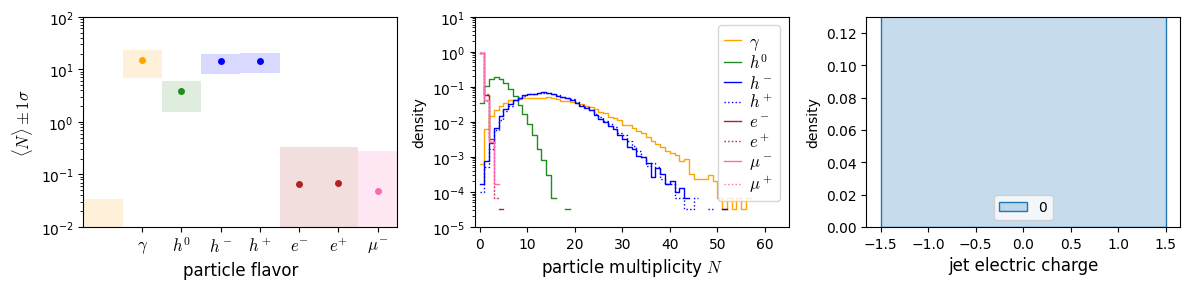

In [7]:
_, ax = plt.subplots(1, 3, figsize=(12, 3))

jets.plot_flavor_count_per_jet(
    markersize=8,
    color=[
        "orange",
        "orange",
        "forestgreen",
        "blue",
        "blue",
        "firebrick",
        "firebrick",
        "hotpink",
        "hotpink",
    ],
    ax=ax[0],
)

fill = False
alpha = 1 

data.histplot('num_Photon',ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1,log_scale=(False, True),  stat='density', color='orange',lw=1,  label=r'$\gamma$')
data.histplot("num_NeutralHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True),  stat='density', color='forestgreen',lw=1,  label=r'$h^0$')
data.histplot("num_NegativeHadron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True) , stat='density', color='blue', lw=1, label=r'$h^-$')
data.histplot("num_PositiveHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True), ls=':', stat='density', color='blue', lw=1, label=r'$h^+$')
data.histplot("num_Electron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1,  label=r'$e^-$')
data.histplot("num_Positron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1, ls=':', label=r'$e^+$')
data.histplot("num_Muon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, label=r'$\mu^-$')
data.histplot("num_AntiMuon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, ls=':', label=r'$\mu^+$')
data.histplot("charge", discrete=True, ax=ax[2], alpha=0.25, label="electric charge", stat='density', )

ax[0].set_xlim(-0.5,7.5)
ax[0].set_ylim(0.01,100)
ax[1].set_ylim(1e-5,10)
ax[1].set_xlim(-1,65)
ax[2].set_ylim(0.0,0.13)

ax[0].set_xlabel('particle flavor', fontsize=12)
ax[1].set_xlabel('particle multiplicity $N$', fontsize=12)
ax[1].set_ylabel('density', fontsize=10)
ax[2].set_xlabel('jet electric charge', fontsize=12)
ax[2].set_ylabel('density', fontsize=10)
ax[1].legend(fontsize=12, loc="upper right", handletextpad=0.5, handlelength=1., labelspacing=0.1)

plt.tight_layout()
plt.savefig("particle_discrete_feats.png", dpi=1000)


plt.show()



In [ ]:
sets.histplot("num_Photon", fill=False, discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
particle_sets.histplot("numElectrons", discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

particle_set, _ = aoj(
    num_jets=10_000,
    download=False,
    features={"continuous":None, "discrete": "tokens"},
)
